<a href="https://colab.research.google.com/github/alvingeorge567/DeepLearningStockPrice/blob/main/FinalPlease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter any ticker symbol (e.g., AAPL, MSFT): TSLA


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM RMSE: 10.857248393074102
Simple Moving Average RMSE: 21.257750282571667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

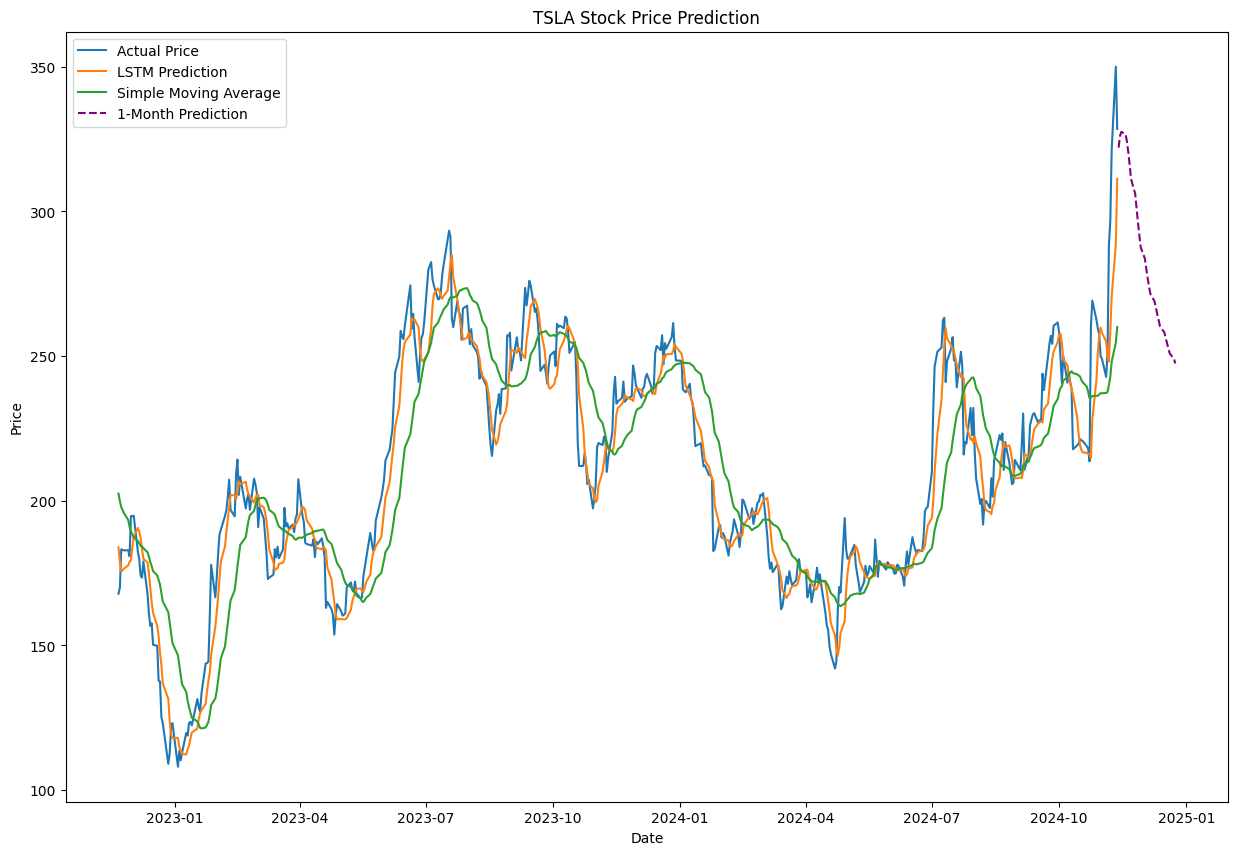

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Function to fetch stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Function to build and train LSTM model
def build_lstm_model(X_train, y_train, epochs=30, batch_size=32):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Function to calculate simple moving average
def simple_moving_average(data, window):
    return data.rolling(window=window).mean()

# Function to predict future stock prices
def predict_future_prices(model, data, scaler, seq_length, days_to_predict=30):
    future_predictions = []
    last_sequence = data[-seq_length:]  # Start with the last available sequence
    for _ in range(days_to_predict):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape(1, seq_length, 1)
        # Predict the next value
        next_pred = model.predict(last_sequence_reshaped)
        # Inverse transform the prediction
        next_pred_inverse = scaler.inverse_transform(next_pred)
        future_predictions.append(next_pred_inverse[0][0])
        # Append the prediction to the sequence and continue
        last_sequence = np.append(last_sequence, next_pred)[1:]  # Slide window
    return future_predictions

def user_input():
    ticker = input("Enter any ticker symbol (e.g., AAPL, MSFT): ")
    return ticker

# Main function
def main():
    # Parameters
    ticker = user_input()
    start_date = '2015-01-01'
    end_date = '2024-11-13'
    train_split = 0.8
    seq_length = 60

    # Fetch data
    stock_data = get_stock_data(ticker, start_date, end_date)

    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    # Split data into train and test sets
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - seq_length:]

    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    # Build and train LSTM model
    lstm_model = build_lstm_model(X_train, y_train)

    # Make predictions
    lstm_predictions = lstm_model.predict(X_test)

    # Inverse transform predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate LSTM RMSE
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
    print(f"LSTM RMSE: {lstm_rmse}")

    # Simple Moving Average
    sma_window = 20
    sma = simple_moving_average(stock_data, sma_window)
    sma_predictions = sma.iloc[-len(y_test):].values

    # Calculate SMA RMSE
    sma_rmse = np.sqrt(mean_squared_error(y_test, sma_predictions))
    print(f"Simple Moving Average RMSE: {sma_rmse}")

    # Predict future stock prices for the next 30 days
    future_predictions = predict_future_prices(lstm_model, scaled_data, scaler, seq_length, days_to_predict=30)

    # Calculate percentage differences
    percent_differences = 100 * np.abs((y_test - lstm_predictions) / y_test)

    # Adjust dates to match y_test and lstm_predictions
    adjusted_dates = stock_data.index[-len(y_test):]

    # Updated Results DataFrame
    results_df = pd.DataFrame({
        'Date': adjusted_dates,
        'Actual Price': y_test.flatten(),
        'Predicted Price': lstm_predictions.flatten(),
        'Percent Difference (%)': percent_differences.flatten()
    })

    # Print last 10 rows for validation
    print("\nStock Price Predictions vs Actual:")
    print(results_df.tail(10))  # Print last 10 results

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(adjusted_dates, y_test, label='Actual Price')
    plt.plot(adjusted_dates, lstm_predictions, label='LSTM Prediction')
    plt.plot(stock_data.index[-len(y_test):], sma_predictions, label='Simple Moving Average')

    # Plot future predictions
    future_dates = pd.date_range(stock_data.index[-1], periods=31, freq='B')[1:]  # Business days for next month
    plt.plot(future_dates, future_predictions, label='1-Month Prediction', linestyle='dashed', color='purple')

    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
